In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing libraries**

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import * 
from keras.models import Sequential
from keras.regularizers import L2
from keras.utils import plot_model
from keras.optimizers import Adam
import cv2
import os
from sklearn.metrics import confusion_matrix
from tensorflow.train import * 

In [4]:
class_name = ['angry','happy','sad']
conf={
    "batch_size" : 32,
    "im_size" : 256,
    "learning_rate":0.001,
    "dropout_rate":0.0,
    "regularization_rate":0.0,
    "filters":6,
    "kernel_size":3,
    "strides":1,
    "pool_size":2
}


In [5]:
train_df = keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/train",
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=conf["batch_size"],
    image_size=(conf["im_size"], conf["im_size"]),
    shuffle=True,
    seed=99)

Found 6799 files belonging to 3 classes.


In [6]:
val_df = keras.utils.image_dataset_from_directory(
    directory = "/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test",
    labels='inferred',
    label_mode='int',
    class_names=class_name,
    color_mode='rgb',
    batch_size=conf["batch_size"],
    image_size=(conf["im_size"], conf["im_size"]),
    shuffle=True,
    seed=99)

Found 2278 files belonging to 3 classes.


In [7]:
for i in val_df.take(1):
    print(i[0][0])

tf.Tensor(
[[[ 20.        20.        20.      ]
  [ 19.1875    19.1875    19.1875  ]
  [ 19.        19.        19.      ]
  ...
  [ 29.125     29.125     29.125   ]
  [ 25.        25.        25.      ]
  [ 25.        25.        25.      ]]

 [[ 20.        20.        20.      ]
  [ 19.847656  19.847656  19.847656]
  [ 19.8125    19.8125    19.8125  ]
  ...
  [ 28.820312  28.820312  28.820312]
  [ 25.660156  25.660156  25.660156]
  [ 25.        25.        25.      ]]

 [[ 20.6875    20.6875    20.6875  ]
  [ 21.246094  21.246094  21.246094]
  [ 21.847656  21.847656  21.847656]
  ...
  [ 25.3125    25.3125    25.3125  ]
  [ 22.375     22.375     22.375   ]
  [ 21.5625    21.5625    21.5625  ]]

 ...

 [[117.8125   117.8125   117.8125  ]
  [117.8125   117.8125   117.8125  ]
  [120.77734  120.77734  120.77734 ]
  ...
  [ 18.964844  18.964844  18.964844]
  [ 16.558594  16.558594  16.558594]
  [ 16.        16.        16.      ]]

 [[113.1875   113.1875   113.1875  ]
  [113.1875   113.1875   1

# **Data Visualization**

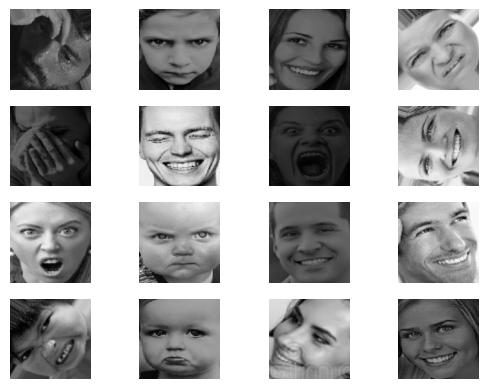

In [8]:
for img,labels in train_df.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(img[i]/255.)
        plt.axis("off")

# **Data Preparation**

In [9]:
train_df = (train_df.prefetch(tf.data.AUTOTUNE))
val_df = (val_df.prefetch(tf.data.AUTOTUNE))

In [10]:
resize_rescale_layer = Sequential([
    Resizing(conf["im_size"],conf["im_size"]),
    Rescaling(1./255)
])

# **Model**

In [11]:
model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3), ),
    
    resize_rescale_layer,
    
    Conv2D(filters = conf['filters'] , kernel_size = conf['kernel_size'], strides = conf['strides'] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides= conf['strides']*2),
    Dropout(rate = conf["dropout_rate"] ),

    Conv2D(filters = conf['filters']*2 + 4, kernel_size = conf['kernel_size'], strides = conf['strides'], padding='valid',
          activation = 'relu', kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides = conf['strides']*2),

    Flatten(),
    
    Dense( 100, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    Dropout(rate = conf["dropout_rate"]),
    
    Dense( 10, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),

    Dense(3, activation = "softmax"),

])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

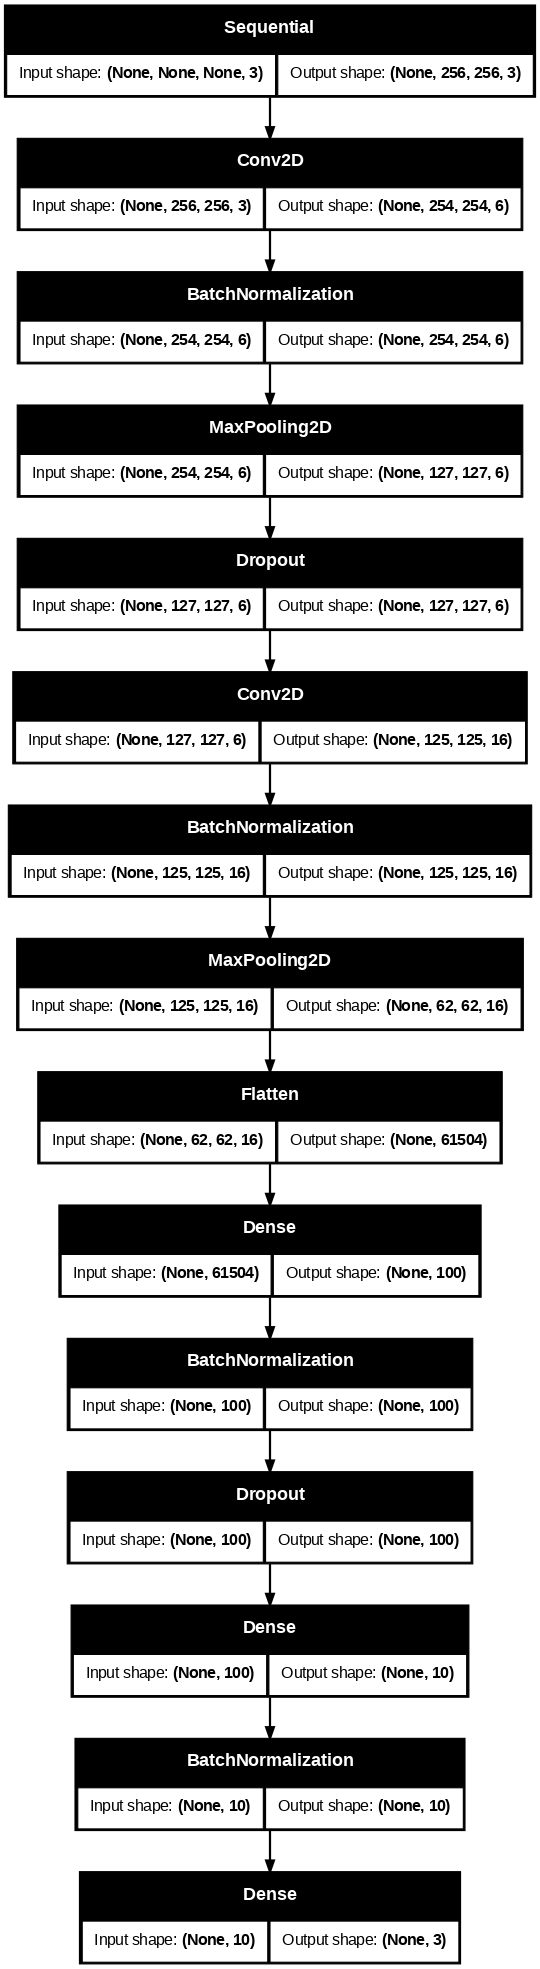

In [12]:
plot_model(model,show_shapes=True,dpi=80)

In [13]:
model.compile(optimizer = Adam(learning_rate=conf['learning_rate']),loss = "SparseCategoricalCrossentropy",metrics=['accuracy'])

In [14]:
hist = model.fit(train_df,validation_data = val_df,epochs = 15,verbose=1)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 99ms/step - accuracy: 0.5288 - loss: 1.1127 - val_accuracy: 0.4816 - val_loss: 1.0245
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.7045 - loss: 0.6969 - val_accuracy: 0.5847 - val_loss: 0.9106
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.7946 - loss: 0.5173 - val_accuracy: 0.6058 - val_loss: 0.9462
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.8662 - loss: 0.3641 - val_accuracy: 0.6084 - val_loss: 1.1570
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9036 - loss: 0.2679 - val_accuracy: 0.7147 - val_loss: 0.7456
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9419 - loss: 0.1771 - val_accuracy: 0.6866 - val_loss: 0.9543
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9510 - loss: 0.1532 - val_accuracy: 0.6295 - val_loss: 1.2128
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.9568 - loss: 0.1279 - val_acc

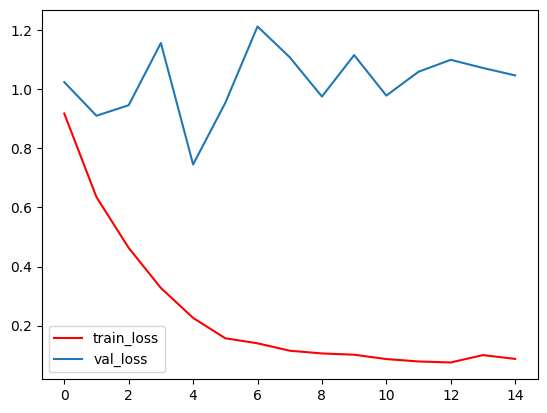

In [15]:
plt.plot(hist.history['loss'],c='red')
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss',"val_loss"])
plt.show()

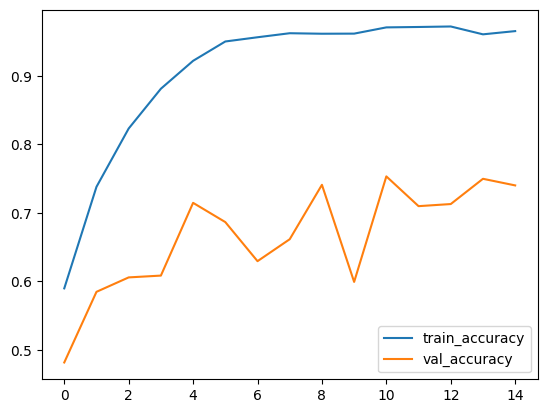

In [16]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_accuracy',"val_accuracy"])
plt.show()

In [17]:
model.evaluate(val_df)

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7383 - loss: 1.0692


[1.0471712350845337, 0.74012291431427]

# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
happy


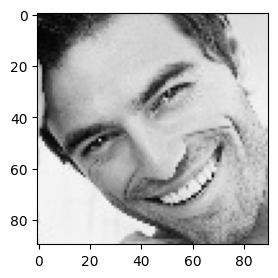

In [18]:
test_img = cv2.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
im = tf.constant(test_img,dtype=tf.float32)
im = tf.expand_dims(im,axis = 0)
print(class_name[tf.argmax(model.predict(im),axis = -1).numpy()[0]])
plt.figure(figsize=(3,3))
plt.imshow(test_img)
plt.show()

# **Data Augmentation**

In [19]:
aug_layer = keras.Sequential([
    RandomRotation(factor=(-0.025,0.025)),
    RandomContrast(factor=0.1),
    RandomFlip(mode='horizontal')
])

In [20]:
def augment_layer(img,label):
    return aug_layer(img,training = True),label

In [21]:
train_data = (
    train_df
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
val_df = (val_df.prefetch(tf.data.AUTOTUNE))

In [22]:
resize_rescale_layer = Sequential([
    Resizing(conf["im_size"],conf["im_size"]),
    Rescaling(1./255)
])

# **CutMix Augmentation**

In [23]:
def box(lamda):
  
  r_x = tf.cast(tfp.distributions.Uniform(0, conf['im_size']).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, conf['im_size']).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, conf['im_size'])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, conf['im_size'])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, conf['im_size'])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, conf['im_size'])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [24]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]
  
  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, conf['im_size'], conf['im_size'])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, conf['im_size'], conf['im_size'])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(conf['im_size']*conf['im_size']), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [25]:
train_dataset_1 = train_df.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_df.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [26]:
train_data = (
    train_df
    .map(augment_layer,num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)
val_df = (val_df.prefetch(tf.data.AUTOTUNE))

In [27]:
resize_rescale_layer = Sequential([
    Resizing(conf["im_size"],conf["im_size"]),
    Rescaling(1./255)
])

In [28]:
model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None,None, 3), ),
    
    resize_rescale_layer,
    
    Conv2D(filters = conf['filters'] , kernel_size = conf['kernel_size'], strides = conf['strides'] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides= conf['strides']*2),
    Dropout(rate = conf["dropout_rate"] ),

    Conv2D(filters = conf['filters']*2 + 4, kernel_size = conf['kernel_size'], strides = conf['strides'], padding='valid',
          activation = 'relu', kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    MaxPool2D (pool_size = conf["pool_size"], strides = conf['strides']*2),

    Flatten(),
    
    Dense( 100, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),
    Dropout(rate = conf["dropout_rate"]),
    
    Dense( 10, activation = "relu", kernel_regularizer = L2(conf['regularization_rate'])),
    BatchNormalization(),

    Dense(3, activation = "softmax"),

])

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

In [29]:
model.compile(optimizer = Adam(learning_rate=conf['learning_rate']),loss = "SparseCategoricalCrossentropy",metrics=['accuracy'])

In [30]:
hist = model.fit(train_data,validation_data = val_df,epochs = 15,verbose=1)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 36s 146ms/step - accuracy: 0.4699 - loss: 1.0971 - val_accuracy: 0.5132 - val_loss: 1.0163
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 133ms/step - accuracy: 0.6032 - loss: 0.8573 - val_accuracy: 0.5470 - val_loss: 0.9439
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.6472 - loss: 0.7757 - val_accuracy: 0.5966 - val_loss: 0.8920
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 29s 132ms/step - accuracy: 0.6976 - loss: 0.7104 - val_accuracy: 0.6585 - val_loss: 0.7514
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.7227 - loss: 0.6473 - val_accuracy: 0.6967 - val_loss: 0.7209
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 128ms/step - accuracy: 0.7410 - loss: 0.6141 - val_accuracy: 0.7164 - val_loss: 0.6618
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.7693 - loss: 0.5574 - val_accuracy: 0.7208 - val_loss: 0.6587
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.7781 - loss: 0

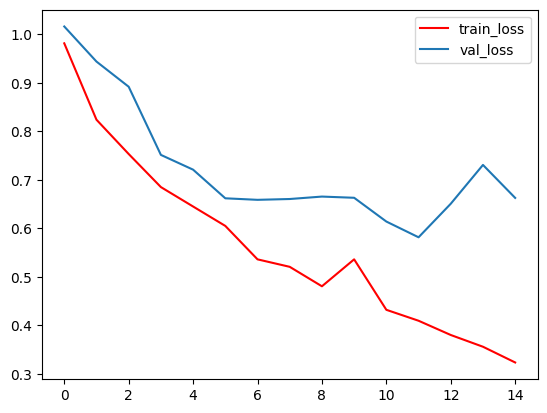

In [31]:
plt.plot(hist.history['loss'],c='red')
plt.plot(hist.history['val_loss'])
plt.legend(['train_loss',"val_loss"])
plt.show()

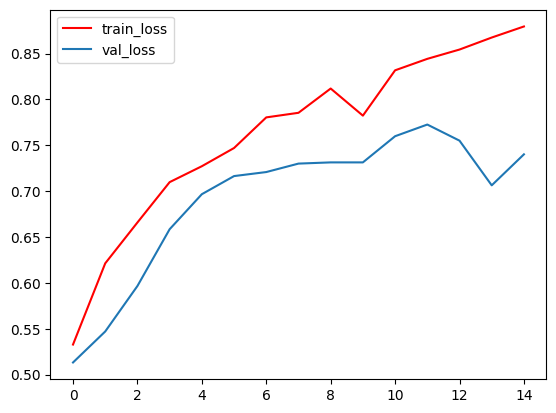

In [32]:
plt.plot(hist.history['accuracy'],c='red')
plt.plot(hist.history['val_accuracy'])
plt.legend(['train_loss',"val_loss"])
plt.show()

# **Prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
sad


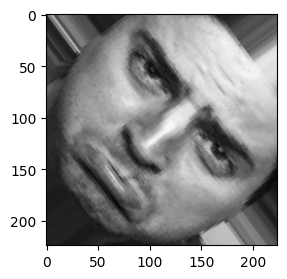

In [37]:
test_img = cv2.imread("/kaggle/input/human-emotions-datasethes/Emotions Dataset/Emotions Dataset/test/sad/108893.jpg_rotation_2.jpg")
im = tf.constant(test_img,dtype=tf.float32)
im = tf.expand_dims(im,axis = 0)
print(class_name[tf.argmax(model.predict(im),axis = -1).numpy()[0]])
plt.figure(figsize=(3,3))
plt.imshow(test_img)
plt.show()